In [2]:
#Pkg.add("Optim")
#Pkg.add("PyPlot")
#Pkg.add("FFTW")

using Pkg
using Optim
using PyPlot
using LinearAlgebra
using FFTW

In [3]:
function ma(x,l)
    n = length(x)
    h = zeros(n,n)
    for i=1:n
        for j=1:n
            if (j < i + l) & (j >= i)
                h[i,j] = 1/l
            end
            
            if ( n < i + l ) & ( ( mod(i+l,n) > j ) | (i+l == 2*n) ) 
                h[i,j] = 1/l
            end
        end
    end
    return h*x
end


X = [1, 1, 2, 2]
L = 2
print(ma(X,L))

[1.0, 1.5, 2.0, 1.5]

In [4]:
function no_win(p,g)
    l = length(p)
    gs = reverse(g(p))
    result = ones(l)
    for i = 2:l
        for j=i:l
            result[i-1] = result[i-1]*gs[j]
        end
    end
    return reverse(result)
end


function create_obj(u,g)
    obj(p) = -1*u(p,g)
    return obj
end


f1(p) = clamp!(p,0, 1)
u1(p,g) = sum(p.*(ones(size(p)) - g(p)).*no_win(p,g))

P = [.5,.5,.5]
res = optimize(create_obj(u1,f1),[.5,.5,.5])

println(res.minimizer)
println(no_win(res.minimizer,f1))
println(f1(res.minimizer))

[0.695226, 0.625048, 0.499877]
[1.0, 0.695226, 0.43455]
[0.695226, 0.625048, 0.499877]


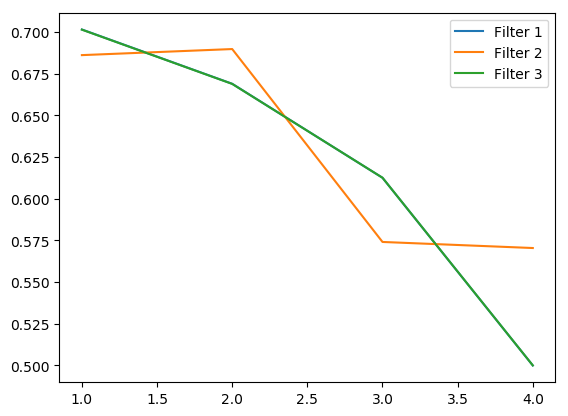

0.37181250000000005

In [7]:
function create_plot(n,l,u,g)
    p0 = .5*ones(n)
    for i=1:l
        obj(p) = create_obj(u,g)(p)
        obj_avg(p) = obj(ma(p,i))
        res = optimize(obj_avg,p0)
        ps = ma(res.minimizer,i)
        xs = collect(1:length(ps))
        plot(xs, ps, label="Filter $(i)")
    end
    legend()
    show()
end

BETA = .9
f1(p) = clamp!(p,0, 1)
u1(p,g) = p.*(ones(size(p)) - g(p)).*no_win(p,g)
u2(p,g) = sum((BETA*ones(length(p))).^collect(1:length(p)) .*u1(p,g))
print(u2(P,f1))
create_plot(4,3,u2,f1)

In [6]:
function update_beliefs(p,g)
    l = length(p)
    gs = g(p)
    result = gs[:]
    for i = 2:l
        result[i] = Int( p[i] < minimum(p[1:i-1]) )*result[i]/gs[i-1]
    end
    return result[:]
end


P = [.7, .6, .5]

function create_obj(u,g)
    obj(p) = -1*u(p,g)
    return obj
end



f1(p) = clamp!(p,0, 1)

u3(p,g) = p .*(ones(size(p))- update_beliefs(p,g))

BETA = 1

u4(p,g) = sum((BETA*ones(length(p))).^collect(1:length(p)) .*u2(p,g))

obj2(p) = create_obj(u4,f1)(p)

res2 = optimize(create_obj(u2,f1),[.5,.4,.3])
println(res2.minimizer)
println(obj2(res2.minimizer))
println(update_beliefs(res2.minimizer,f1))
println(f1(res2.minimizer))

[0.695327, 0.625027, 0.499949]
-1.4503784124488444
[0.695327, 0.898896, 0.799884]
[0.695327, 0.625027, 0.499949]
